# Collecting and exploring data from monitoring stations 

In [3]:
import pandas as pd
import requests
from datetime import datetime, timedelta
import os
import sys
from geopy.geocoders import Nominatim
import pandas as pd
import datetime as dt
import matplotlib

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
sys.path.append(os.path.dirname(os.getcwd()))
print(sys.path)

['c:\\Users\\mikes\\Documents\\STUDY\\mlops-zoomcamp\\air_pollution\\notebooks', 'c:\\Users\\mikes\\anaconda3\\envs\\py11\\python311.zip', 'c:\\Users\\mikes\\anaconda3\\envs\\py11\\DLLs', 'c:\\Users\\mikes\\anaconda3\\envs\\py11\\Lib', 'c:\\Users\\mikes\\anaconda3\\envs\\py11', '', 'C:\\Users\\mikes\\AppData\\Roaming\\Python\\Python311\\site-packages', 'C:\\Users\\mikes\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32', 'C:\\Users\\mikes\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32\\lib', 'C:\\Users\\mikes\\AppData\\Roaming\\Python\\Python311\\site-packages\\Pythonwin', 'c:\\Users\\mikes\\anaconda3\\envs\\py11\\Lib\\site-packages', 'c:\\Users\\mikes\\anaconda3\\envs\\py11\\Lib\\site-packages\\win32', 'c:\\Users\\mikes\\anaconda3\\envs\\py11\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\mikes\\anaconda3\\envs\\py11\\Lib\\site-packages\\Pythonwin', 'c:\\Users\\mikes\\Documents\\STUDY\\mlops-zoomcamp\\air_pollution']


In [6]:
HOURS = 24*7

In [7]:
from src.config import PROCESSED_DATA_DIR, RAW_DATA_DIR, PROJ_ROOT

In [8]:
from scrpts.data_from_stations import get_weather_data
from scrpts.data_from_stations import get_weather_data_timeInterval
from scrpts.data_from_stations import get_air_pollution_data_timeInterval
from scrpts.data_from_stations import get_air_pollution_data
from scrpts.wfs import get_stored_query_descriptions

In [9]:
def show_weather():    
  
    address = 'Helsinki'
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude_city = location.latitude
    longitude_city = location.longitude   
    #print("latt, long", latitude_city, longitude_city)
    
    weather_data, weather_stations = get_weather_data(latitude_city, longitude_city, 20)

    print("data:", weather_data)
    #print("stations: ", stations)

    latest_weather_info = {}

    for name, info in weather_stations.items():
       
        weather_info_station = list(weather_data[name].values())[0]
        #print(list(weather_data[name].keys())[0])

        latest_weather_info[name] = { "Lattitude": info['latitude'], 
                                      "Longitude": info['longitude'],
                                      "Timestamp": list(weather_data[name].keys())[0],  
        "Air temperature":  weather_info_station["Air temperature"]["value"],
        "Wind speed":  weather_info_station["Wind speed"]["value"],
        "Wind direction":  weather_info_station["Wind direction"]["value"],
        "Gust speed": weather_info_station["Gust speed"]["value"],
        "Relative humidity": weather_info_station["Relative humidity"]["value"],
        "Cloud": weather_info_station["Cloud amount"]["value"] }
        
    # Convert to HTML
    #map_html = map._repr_html_()
    #print(weather_info_station)

    return latest_weather_info

In [10]:
filtered_desc =  [desc for desc in get_stored_query_descriptions() if  "air" in desc.lower()]

In [11]:
def show_air_pollution():    
  
    address = 'Helsinki'
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude_city = location.latitude
    longitude_city = location.longitude   
    print("latt, long", latitude_city, longitude_city)
    
    air_data, air_stations = get_air_pollution_data(latitude_city, longitude_city, 20)

    print("data:", air_data)
    print("stations: ", air_stations)

    latest_air_info = {}

    for name, info in air_stations.items():
       
        air_info_station = list(air_data[name].values())[0]
        #print(list(weather_data[name].keys())[0])

        latest_air_info[name] = { "Lattitude": info['latitude'], 
                                      "Longitude": info['longitude'],
                                      "Timestamp": list(air_data[name].keys())[0],  
        "Nitrogen monoxide":  air_info_station["Nitrogen monoxide"]["value"],
        "Nitrogen dioxide": air_info_station["Nitrogen dioxide"]["value"],
        "Particulate matter < 10 µm": air_info_station["Particulate matter < 10 µm"]["value"],
        "Particulate matter < 2.5 µm": air_info_station["Particulate matter < 2.5 µm"]["value"]}
        
    # Convert to HTML
    #map_html = map._repr_html_()

    #print(weather_info_station)

    return latest_air_info

In [17]:
address = 'Helsinki'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_city = location.latitude
longitude_city = location.longitude   

week_number = 1

air_pollution_total = {}

for n in range(week_number):

    start = dt.datetime.now() - (n+1)*dt.timedelta(hours=HOURS)
    end = dt.datetime.now() - n*dt.timedelta(hours=HOURS)

    air_pollution_week= get_air_pollution_data_timeInterval( latitude_city, longitude_city, 
                                  square_side =20, 
                                  start = start, 
                                  end = end)
    
    air_pollution_week = list(air_pollution_week)[0]

    for key in air_pollution_week.keys():
        
        if key not in air_pollution_total.keys():
            air_pollution_total[key] = air_pollution_week[key]
        else:
            air_pollution_total[key] = air_pollution_total[key] +  air_pollution_week[key]

    
    print(len(     air_pollution_total[ list( air_pollution_total.keys() ) [0] ]  )  )
    print(len(     air_pollution_week[ list( air_pollution_week.keys() ) [0] ]  )  )



168
168


In [19]:
air_pollution_stations= list(air_pollution_total.keys())
# Loop through all air pollution stations
for station in air_pollution_stations:
    merged_df_list = []
    timestamp = []
    
    # Process data for the current station
    for x in air_pollution_total[station]:
        df = pd.DataFrame(x.values())
        
        # Convert nested values to floats
        for col in df.columns:
            if col != "Timestamp":
                df[col] = df[col].apply(lambda x: x['value'])
                df[col] = df[col].astype(float)
        
        merged_df_list.append(df)
        timestamp.append(list(x.keys())[0])
    
    # Combine all data for the current station
    merged_df = pd.concat(merged_df_list, ignore_index=True)
    merged_df["Timestamp"] = timestamp
    merged_df["Timestamp"] = pd.to_datetime(merged_df["Timestamp"])
    merged_df["Station"] = station
    
    # Select relevant columns
    merged_df = merged_df[[
        "Timestamp", 
        "Nitrogen monoxide", 
        "Nitrogen dioxide", 
        "Particulate matter < 10 µm", 
        "Particulate matter < 2.5 µm"
    ]]
    
    # Resample to 1-hour intervals and calculate averages
    #merged_df.set_index("Timestamp", inplace=True)
    #merged_df_avg = merged_df.resample("1H").mean()
    #merged_df_avg["Station"] = station
    #merged_df_avg["Timestamp"] = merged_df_avg.index
    #merged_df_avg.reset_index(drop=True, inplace=True)
    
    ## Save to CSV file with station name in the filename
    filename = f"{station.replace(' ', '_')}_air_pollution_data.csv"
    full_path = os.path.join(RAW_DATA_DIR, filename)
    merged_df.to_csv(full_path, index=False)
    print(f"Saved data for station: {station} to {filename}, length: {len(merged_df)}")

Saved data for station: Helsinki Kallio 2 to Helsinki_Kallio_2_air_pollution_data.csv, length: 168
Saved data for station: Espoo Leppävaara Läkkisepänkuja to Espoo_Leppävaara_Läkkisepänkuja_air_pollution_data.csv, length: 168
Saved data for station: Espoo Luukki to Espoo_Luukki_air_pollution_data.csv, length: 168
Saved data for station: Helsinki Mannerheimintie to Helsinki_Mannerheimintie_air_pollution_data.csv, length: 168
Saved data for station: Vantaa Tikkurila Neilikkatie to Vantaa_Tikkurila_Neilikkatie_air_pollution_data.csv, length: 168
Saved data for station: Helsinki Vartiokylä Huivipolku to Helsinki_Vartiokylä_Huivipolku_air_pollution_data.csv, length: 168
Saved data for station: Helsinki Katajanokka 2 to Helsinki_Katajanokka_2_air_pollution_data.csv, length: 168
Saved data for station: Espoo Lintuvaara 2 to Espoo_Lintuvaara_2_air_pollution_data.csv, length: 168
Saved data for station: Helsinki Teollisuuskatu to Helsinki_Teollisuuskatu_air_pollution_data.csv, length: 168
Saved

In [14]:
air_pollution_stations

['Helsinki Kallio 2',
 'Espoo Leppävaara Läkkisepänkuja',
 'Espoo Luukki',
 'Helsinki Mannerheimintie',
 'Vantaa Tikkurila Neilikkatie',
 'Helsinki Vartiokylä Huivipolku',
 'Helsinki Katajanokka 2',
 'Espoo Lintuvaara 2',
 'Helsinki Teollisuuskatu',
 'Helsinki Tapanila 2',
 'Vantaa Kehä III Viinikkala',
 'Helsinki Kustaa Vaasan tie']

<Axes: xlabel='Timestamp'>

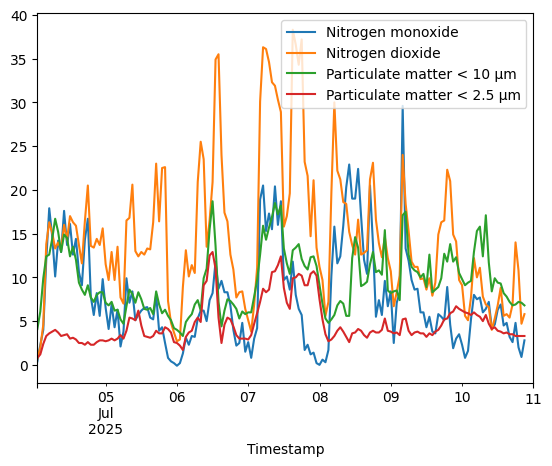

In [20]:
merged_df.plot(x = "Timestamp", y = ["Nitrogen monoxide",
                                    "Nitrogen dioxide", 
                                    "Particulate matter < 10 µm",
                                    "Particulate matter < 2.5 µm"])

forming database for air pollution

In [16]:
for k,v in  weather_week.items():
    print(k, len(v))
    

NameError: name 'weather_week' is not defined

In [ ]:
weather_week = get_weather_data_timeInterval( latitude_city, longitude_city, 
                                  square_side =20, 
                                  start = start, 
                                  end = end)
    
#print(weather_week.keys())
weather_week = list(weather_week)[0]

In [ ]:
df.head()


Air temperature  Wind speed  Gust speed  Wind direction  Relative humidity  \
0              9.1         1.2         3.8           252.0               36.0   

   Dew-point temperature  Precipitation amount  Precipitation intensity  \
0                   -5.1                   NaN                      0.0   

   Snow depth  Pressure (msl)  Horizontal visibility  Cloud amount  \
0         0.0          1017.3                47816.0           8.0   

   Present weather (auto)           Timestamp  
0                     0.0 2025-05-09 09:30:00

In [ ]:
weather_week1= weather_week.copy() 

df = pd.DataFrame()
for x in weather_week1["Espoo Tapiola"]:
    
    for key in x.keys():
        
        dict = {}
        for k in x[key].keys():
            
            y = x[key][k]['value']
            
            dict[k] = y

        #print(dict)
        df = pd.concat([df, pd.DataFrame([dict])], ignore_index=True)
        df["Timestamp"] = key

df = df[["Timestamp", "Air temperature", "Wind speed", "Gust speed"]]

df.set_index("Timestamp", inplace=True)
df = df.resample("1H").mean()
df["Timestamp"] = df.index

C:\Users\mikes\AppData\Local\Temp\ipykernel_14960\3877908245.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample("1H").mean()


In [ ]:
df.head()

Air temperature  Wind speed  Gust speed  \
Timestamp                                                      
2025-05-09 09:00:00         6.093077    2.869231    4.510769   

                              Timestamp  
Timestamp                                
2025-05-09 09:00:00 2025-05-09 09:00:00

In [ ]:
weather_week_l = list(weather_week)[0]
weather_week_l


{'Vantaa Helsinki-Vantaan lentoasema': [{datetime.datetime(2025, 5, 8, 11, 52): {'Air temperature': {'value': 6.0,
     'units': 'degC'},
    'Wind speed': {'value': 4.0, 'units': 'm/s'},
    'Gust speed': {'value': 5.8, 'units': 'm/s'},
    'Wind direction': {'value': 15.0, 'units': 'deg'},
    'Relative humidity': {'value': 44.0, 'units': '%'},
    'Dew-point temperature': {'value': -5.3, 'units': 'degC'},
    'Precipitation amount': {'value': nan, 'units': 'mm'},
    'Precipitation intensity': {'value': nan, 'units': 'mm/h'},
    'Snow depth': {'value': nan, 'units': 'cm'},
    'Pressure (msl)': {'value': 1018.1, 'units': 'hPa'},
    'Horizontal visibility': {'value': 66647.0, 'units': 'm'},
    'Cloud amount': {'value': 8.0, 'units': '1/8'},
    'Present weather (auto)': {'value': 0.0, 'units': ''}}},
  {datetime.datetime(2025, 5, 8, 11, 53): {'Air temperature': {'value': 6.2,
     'units': 'degC'},
    'Wind speed': {'value': 4.1, 'units': 'm/s'},
    'Gust speed': {'value': 5.8, 

In [ ]:
address = 'Helsinki'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_city = location.latitude
longitude_city = location.longitude   

week_number = 4

day_number = 1

HOURS_day = 24

weather_week_total = {}

df_total = pd.DataFrame()
for n in range(day_number):
    print(n)

    start = dt.datetime.now() - (n+1)*dt.timedelta(hours=HOURS_day)
    end = start + dt.timedelta(hours=HOURS_day)
    #nd = start + dt.timedelta(minutes=60*10)

    weather_week = get_weather_data_timeInterval( latitude_city, longitude_city, 
                                  square_side =20, 
                                  start = start, 
                                  end = end)
    
    #print(weather_week.keys())
    weather_week = list(weather_week)[0]

    #####################3

    stations = list(weather_week.keys())

    df_all_stations = pd.DataFrame()    
    for station in stations:

        df = pd.DataFrame()
        for x in weather_week[station]:
    
            for key in x.keys():        
                
                dict = {}

                for k in x[key].keys():
            
                    y = x[key][k]['value']
            
                    dict[k] = y

                dict["Timestamp"] = key  
             #print(dict)
                df = pd.concat([df, pd.DataFrame([dict])], ignore_index=True)
                #df["Timestamp"] = key

        df = df[["Timestamp", "Air temperature", "Wind speed", "Gust speed"]]

        df.set_index("Timestamp", inplace=True)
        df = df.resample("1H").mean()
        df["Timestamp"] = df.index
        
        df_all_stations = pd.concat([df_all_stations, df], ignore_index=False)
        df_all_stations["Station"] = station
    #####################3

    df_total = pd.concat([df_total, df_all_stations], ignore_index=False)
    df_total.reset_index(drop=True, inplace=True)
    #print(weather_week)
    #for key in weather_week:
    #    if key not in weather_week_total.keys():
    #        weather_week_total[key] = weather_week[key]
#
    #    else:
    #        weather_week_total[key] = weather_week_total[key] +  weather_week[key]

    #print(len(     weather_week_total[ list( weather_week_total.keys() ) [0] ]  )  )
##############################################


0


C:\Users\mikes\AppData\Local\Temp\ipykernel_14960\1621347651.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample("1H").mean()
C:\Users\mikes\AppData\Local\Temp\ipykernel_14960\1621347651.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample("1H").mean()
C:\Users\mikes\AppData\Local\Temp\ipykernel_14960\1621347651.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample("1H").mean()
C:\Users\mikes\AppData\Local\Temp\ipykernel_14960\1621347651.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample("1H").mean()
C:\Users\mikes\AppData\Local\Temp\ipykernel_14960\1621347651.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample("1H").mean()
C:\Users\m

In [ ]:
df_total.head(20)

Air temperature  Wind speed  Gust speed           Timestamp        Station
0          6.783721    4.276744    6.779070 2025-05-08 14:00:00  Espoo Tapiola
1          6.736667    4.033333    6.116667 2025-05-08 15:00:00  Espoo Tapiola
2          6.561667    3.478333    5.100000 2025-05-08 16:00:00  Espoo Tapiola
3          6.320000    2.815000    4.266667 2025-05-08 17:00:00  Espoo Tapiola
4          5.800000    1.686667    2.468333 2025-05-08 18:00:00  Espoo Tapiola
5          5.121667    1.811667    2.453333 2025-05-08 19:00:00  Espoo Tapiola
6          3.151667    2.030000    2.256667 2025-05-08 20:00:00  Espoo Tapiola
7          2.306667    2.561667    2.828333 2025-05-08 21:00:00  Espoo Tapiola
8          2.856667    2.833333    3.300000 2025-05-08 22:00:00  Espoo Tapiola
9          2.983333    2.765000    3.343333 2025-05-08 23:00:00  Espoo Tapiola
10         2.663333    2.151667    2.686667 2025-05-09 00:00:00  Espoo Tapiola
11         2.188333    2.245000    2.708333 2025-05-09 01:00:00  Espoo Tapiola
12         1.766667    2.095000    2.448333 2025-05-09 02:00:00  Espoo Tapiola
13         2.100000    2.700000    3.308333 2025-05-09 03:00:00  Espoo Tapiola
14         4.401667    2.915000    3.920000 2025-05-09 04:00:00  Espoo Tapiola
15         7.175000    2.915000    4.525000 2025-05-09 05:00:00  Espoo Tapiola
16         7.381667    2.561667    4.510000 2025-05-09 06:00:00  Espoo Tapiola
17         7.785000    2.851667    5.016667 2025-05-09 07:00:00  Espoo Tapiola
18         7.856667    2.443333    4.168333 2025-05-09 08:00:00  Espoo Tapiola
19         7.916667    3.796667    6.175000 2025-05-09 09:00:00  Espoo Tapiola

In [ ]:
# Loop through all stations

for station in list(df_total["Station"].unique()):    
    
    # Save to CSV file with station name in the filename
    filename = f"{station.replace(' ', '_')}_weather_data.csv"

    full_path = os.path.join(RAW_DATA_DIR, filename)
    df_total[df_total["Station"] == station].to_csv(full_path, index=False)
    
    print(f'Saved data for station: {station} to {filename}, length: { len( df_total[df_total["Station"] == station] ) }')

Saved data for station: Espoo Tapiola to Espoo_Tapiola_weather_data.csv, length: 198


make weather datasets

<Axes: xlabel='Timestamp'>

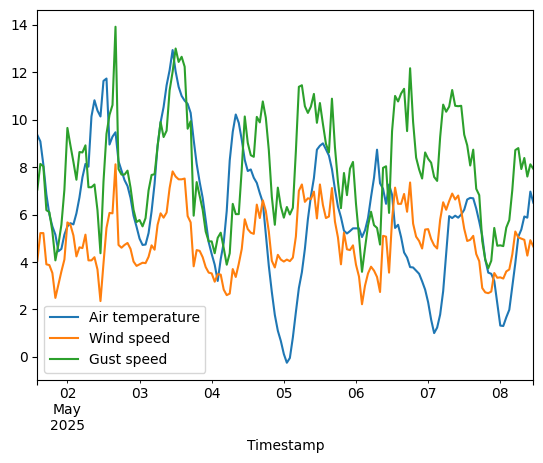

In [ ]:
merged_df_avg.plot(x = "Timestamp", y = ["Air temperature",	"Wind speed",	"Gust speed"])

In [ ]:
data_air_pollution = show_air_pollution()
data_weather = show_weather()

latt, long 60.1674881 24.9427473
data: {'Helsinki Kallio 2': {datetime.datetime(2025, 5, 9, 8, 0): {'Sulphur dioxide': {'value': 0.3, 'units': 'ug/m3'}, 'Nitrogen monoxide': {'value': 0.5, 'units': 'ug/m3'}, 'Nitrogen dioxide': {'value': 3.3, 'units': 'ug/m3'}, 'Ozone': {'value': 76.5, 'units': 'ug/m3'}, 'Odorous sulphur compounds': {'value': nan, 'units': 'ugS/m3'}, 'Carbon monoxide': {'value': nan, 'units': 'ug/m3'}, 'Particulate matter < 10 µm': {'value': 9.1, 'units': 'ug/m3'}, 'Particulate matter < 2.5 µm': {'value': 2.1, 'units': 'ug/m3'}, 'Air Quality Index': {'value': 2.0, 'units': 'index'}, 'musta hiili PM2.5': {'value': 0.08, 'units': 'ug/m3'}}}, 'Espoo Leppävaara Läkkisepänkuja': {datetime.datetime(2025, 5, 9, 8, 0): {'Sulphur dioxide': {'value': nan, 'units': 'ug/m3'}, 'Nitrogen monoxide': {'value': 1.0, 'units': 'ug/m3'}, 'Nitrogen dioxide': {'value': 4.1, 'units': 'ug/m3'}, 'Ozone': {'value': nan, 'units': 'ug/m3'}, 'Odorous sulphur compounds': {'value': nan, 'units': 'ug

In [ ]:
import folium
from folium import Popup
from geopy.geocoders import Nominatim

# Example data (replace with your actual data)


# Initialize a map centered on Helsinki
m = folium.Map(location=[60.1695, 24.9354], zoom_start=10)

# Add markers for each location
for location, info in data_air_pollution.items():
    coords = info['Lattitude'], info['Longitude']
    air_data = data_air_pollution
    
    # Create a popup with air quality information
    popup_content = f"<b>{location}</b><br>"


    #print(info)
    for pollutant, value in info.items():
        popup_content += f"{pollutant}: {value if value is not None else 'N/A'}<br>"
    
    popup = Popup(popup_content, max_width=300)
    
    # Add a marker to the map
    folium.Marker(location=coords, popup=popup).add_to(m)

# Add markers for each location
for location, info in data_weather.items():
    coords = info['Lattitude'], info['Longitude']
    air_data = data_air_pollution
    
    # Create a popup with air quality information
    popup_content = f"<b>{location}</b><br>"

    #print(info)
    for pollutant, value in info.items():
        popup_content += f"{pollutant}: {value if value is not None else 'N/A'}<br>"
    
    popup = Popup(popup_content, max_width=300)
    
    # Add a marker to the map
    #sfolium.Marker(location=coords, popup=popup).add_to(m)
    # Add a marker with a custom color
    folium.Marker(
        location=coords,
        popup=popup,
        icon=folium.Icon(color="red")  # Change "red" to your desired color (e.g., "blue", "green", etc.)
    ).add_to(m)

# Display the map
m